In [3]:
import healpy



def CaloreRegion(region, l, b):
    '''
    Returns a mask corresponding to Calore et al (1409.0042  figure 15 regions)
    
    :params region: Integer region index from 1 to 10
    :params l: Longitude vector of pixels between -180,180
    :params b: Latitude vector of pixels between -90,90
    '''
    
#     pixels = np.arange(12*self.nside**2)
#     l, b = Tools.hpix2ang(pixels, nside=self.nside) # Find l,b of each pixel
#     r = Tools.Dist(0, l, 0, b)  # Find distance from origin
#     mask = np.zeros(pixels.shape)
#     l[l>180] -= 360
    
    if region==1:
        idx = (np.sqrt(l**2+b**2)<5) & (b>2)
    elif region==2:
        idx = (np.sqrt(l**2+b**2)<5) & (-b>2)
    
    elif region==3:
        idx = (5<np.sqrt(l**2+b**2)) & (b>np.abs(l)) & (np.sqrt(l**2+b**2)<10) 
    elif region==4:
        idx = (5<np.sqrt(l**2+b**2)) & (-b>np.abs(l)) & (np.sqrt(l**2+b**2)<10) 
    
    elif region==5:
        idx = (10<np.sqrt(l**2+b**2)) & (b>np.abs(l)) & (np.sqrt(l**2+b**2)<15) 
    elif region==6:
        idx = (10<np.sqrt(l**2+b**2)) & (-b>np.abs(l)) & (np.sqrt(l**2+b**2)<15) 
    
    elif region==7:
        idx = (5<np.sqrt(l**2+b**2)) & (l>np.abs(b)) & (np.sqrt(l**2+b**2)<15)
    elif region==8:
        idx = (5<np.sqrt(l**2+b**2)) & (-l>np.abs(b)) & (np.sqrt(l**2+b**2)<15) 
    
    elif region==9:
        idx = (15<np.sqrt(l**2+b**2)) & (np.sqrt(l**2+b**2)<20)
    
    elif region==10:
        idx =  np.sqrt(l**2+b**2)>20 
    else: 
        raise('Invalud Calore region. Must be int in 1...10')
    
    mask = (idx & (np.abs(l)<20) & (np.abs(b)<20) & (np.abs(b)>2))
    
    return mask



def GenRegionsMask(self, region):
    '''
    Generate masks for the Calore et al

    :params region: Integer region index from 1 to 10
    '''

    
    pixels = np.arange(12*self.nside**2)
    l, b = Tools.hpix2ang(pixels, nside=self.nside) # Find l,b of each pixel
    r = Tools.Dist(0, l, 0, b)  # Find distance from origin
    mask = np.zeros(pixels.shape)
    l[l>180] -= 360
    
    
    
    mask = CaloreRegion(region,l,b)

    return mask


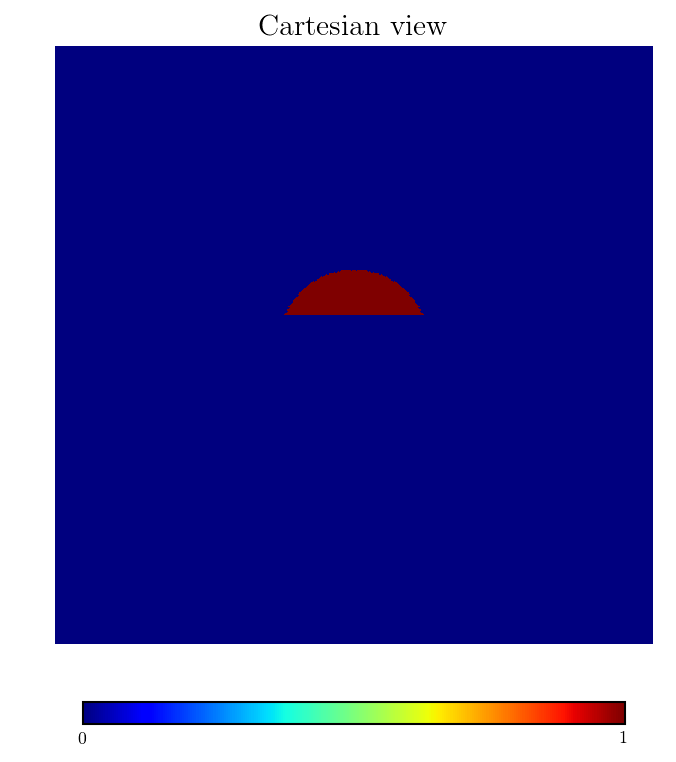

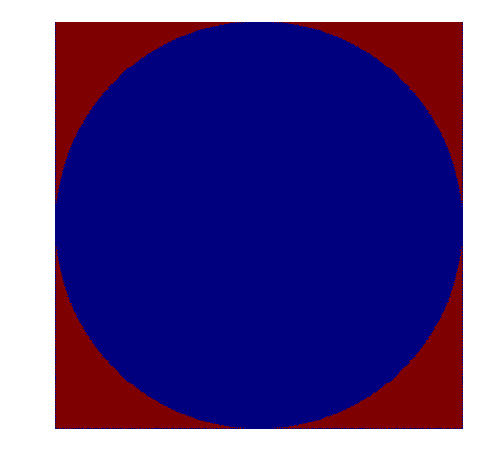

In [4]:
import Tools
pixels = np.arange(12*512**2)
l, b = Tools.hpix2ang(pixels, nside=512) # Find l,b of each pixel
r = Tools.Dist(0, l, 0, b)  # Find distance from origin
mask = np.zeros(pixels.shape)
l[l>180] -= 360

healpy.cartview(CaloreRegion(1, l, b ), latra=(-20,20), lonra=(-20,20))
plt.show()
region_list = [healpy.cartview(CaloreRegion(i, l, b ), hold=True, title='', cbar=None, latra=[-20,20], lonra=[-20,20], return_projected_map=True) for i in range(1,11)]

0.204807506304
0.197329384888
0.207269570939
0.23237485181
0.190710762593
0.203115099556
0.209124180948
0.218160009612
0.189828875357
0.188192041186


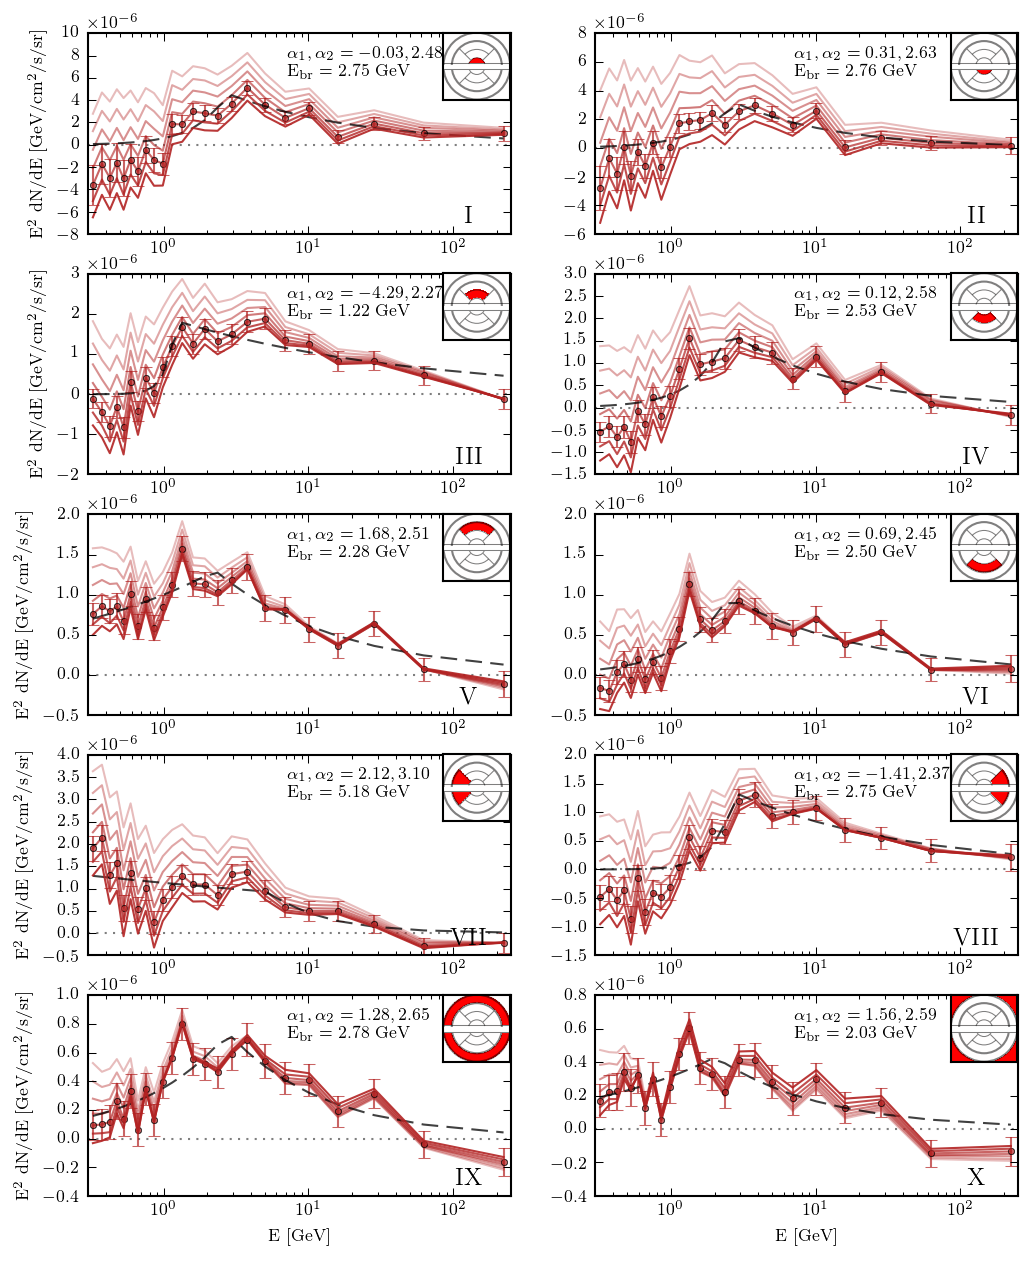

In [6]:
import cPickle as pickle
import h5py
import sys
sys.path.append('/data/GCE_sys/')
import Analysis



import warnings
warnings.filterwarnings("ignore")

import iminuit 
import h5py


def BPLSpec(E, norm, index1, index2, E_break):
    return norm*5e-9*   np.piecewise(E, ((E<E_break), (E>=E_break)), (lambda E: (E/E_break)**-index1, lambda E: (E/E_break)**-index2))
    

def FitSpectrumBPL(E, flux, fluxunc, index1=None, index2=None, E_break=None, print_level=1):
    '''
    Fit a broken-power-law spectrum to the input data.
    
    :params E: energies corresponding to flux
    :params flux: flux of spectrum
    :params fluxunc: uncertainty on flux (single gaussian value)
    :params index1: Low energy spectral index. if None, float, otherwise fix to specified value
    :params index2: High energy spectral index. if None, float, otherwise fix to specified value
    :params E_break: Break energy in units of the input spectrum.
    '''
    
    # If fit didn't converge, errors are zero. Make them infinite here instead so the points don't bias fits.
#     fluxunc2 = fluxunc.copy()
#     print flux, fluxunc
#     fluxunc2[flux < 0] = 1e10
#     print fluxunc2/flux
    
    def f(norm, index1, index2, E_break):
        '''Calculate chisq'''
        model = BPLSpec(E, norm, index1, index2, E_break)        
        chisq = np.sum( (flux-model)**2/fluxunc**2 )
        return np.log(chisq)
            
    E_break_val=2.
    E_break_fixed = False
    if E_break is not None:
        E_break_val = E_break
        E_break_fixed=True
        
    index1_val=2
    index1_fixed = False
    if index1 is not None:
        index1_val = index1
        index1_fixed=True
    
    index2_val=3
    index2_fixed = False
    if index2 is not None:
        index2_val = index2
        index2_fixed=True
    
    
    m = iminuit.Minuit( f, print_level=print_level, index1=index1_val, norm=1., index2=index2_val, E_break=E_break_val, errordef=1., 
                        error_norm=.5, error_E_break=.1, error_index1=.1, error_index2=.1,
                        limit_index1=[-5,None],  limit_norm=[0,None],  limit_index2=[-5,None], limit_E_break=[0,None],
                      fix_E_break=E_break_fixed, fix_index1=index1_fixed, fix_index2=index2_fixed)
    m.migrad()
    try: 
        m.minos()
    except: 
        m.hesse()
    reduced_chisq = m.fval/(len(flux)-4-1) # 4 params, reduced chisq

    return m, reduced_chisq

from collections import OrderedDict

def write_roman(num):

    roman = OrderedDict()
    roman[1000] = "M"
    roman[900] = "CM"
    roman[500] = "D"
    roman[400] = "CD"
    roman[100] = "C"
    roman[90] = "XC"
    roman[50] = "L"
    roman[40] = "XL"
    roman[10] = "X"
    roman[9] = "IX"
    roman[5] = "V"
    roman[4] = "IV"
    roman[1] = "I"

    def roman_num(num):
        for r in roman.keys():
            x, y = divmod(num, r)
            yield roman[r] * x
            num -= (r * x)
            if num > 0:
                roman_num(num)
            else:
                break

    return "".join([a for a in roman_num(num)])

def PlotRegionsSpectra(start, stop, text, fit_vals=True, path='regions', textloc=[.05, .9]):
    
    A = Analysis.Analysis(nside=256)
    npix_roi = np.nonzero(A.GenSquareMask(l_range=(-20,20), b_range=(-20,20), plane_mask=2))[0].shape[0]
    area_ratios = None
    models = ['mod_s_%i_XCO_P8_corrected_stripped.hdf5'%i for i in range(start, stop)]
    
    
    for i, model in enumerate(models):
        if i%1==0:
            #if i > 0: continue
            h = h5py.File('./new/'+model)
            fit = h['/fit_results/'+path].attrs
            avR = range(1,11)
            
            E = fit['energies']
            
            # Find closest energy
            #E_bin = np.argmin(np.abs(energy-E))
            
            if area_ratios is None:
                area_ratios = [npix_roi/float(np.nonzero(A.CaloreRegion(i_r)*A.GenSquareMask(l_range=(-20,20), b_range=(-20,20), plane_mask=2))[0].shape[0]) for i_r in avR]
            
            radial_prof = [area_ratios[i_r-1]*E**2/1e3*fit['flux_region_%i'%i_r] for i_r in avR]
            radial_prof_unc = np.array([area_ratios[i_r-1]*E**2/1e3*fit['fluxunc_region_%i'%i_r][:,1] for i_r in avR])
            
            
            
            for i_r in avR:    
                #if i_r != 1: continue
                plt.subplot(5,2,i_r)
                if (i == 3 and start<28) or (i==4 and start>27):
                    
                    
                    
              
                    plt.hlines(0,.3,500,linestyle=':',alpha=0.5)
                    #plt.text(.8, .9, r'Region %i'%i_r, transform=plt.gca().transAxes, fontsize=8, color='k')    
                    
                    
                    if i_r in [1,3,5,7,9]:
                        plt.ylabel(r'$\rm{E^2\ dN/dE\ [GeV/cm^2/s/sr]}$', fontsize=8)
                    if i_r in [9,10]:
                        plt.xlabel(r'$\rm{E\ [GeV]}$', fontsize=8)
                    plt.errorbar(E/1e3, radial_prof[i_r-1], radial_prof_unc[i_r-1,], color='firebrick', alpha=(i+3)/10., marker='o',markersize=3)
                    
                    if fit_vals==True:
                        # ------------------------------------------------------------
                        # FITTING THE SPECTRUM 
                        fit_E = E/1e3
                        flux = radial_prof[i_r-1]/(fit_E**2*1e3)
                        fluxunc = radial_prof_unc[i_r-1]/(fit_E**2*1e3)
                        bad_bins = []
                        for i_f, fu in enumerate(fluxunc):
                            if fu==0:
                                fluxunc[i_f] = 1e50
                                bad_bins.append(i_f)

                        m, reduced_chisq = FitSpectrumBPL(fit_E, flux, fluxunc, print_level=0, E_break=None)
                        print reduced_chisq
                        for i in bad_bins: 
                            fluxunc[i] = 0

                        model = BPLSpec(E/1e3,**m.values)
                        plt.loglog(E/1e3, E**2/1e3*model, color='k', dashes=[8, 4], alpha=.75)
                        E_br = m.values['E_break']

                        try:
                            xerr = (np.abs((m.get_merrors()['E_break'].lower, m.get_merrors()['E_break'].upper),),).T
                        except:
                            xerr = m.errors['E_break']
                    
                        x_lab, y_lab = 0.47, 0.87
                        #plt.errorbar(E_br,plt.ylim()[0], xerr=xerr, marker='o',markersize=4, color='k')
                        plt.text(x_lab, y_lab, r'$\alpha_1, \alpha_2 = %1.2f, %1.2f$'%(m.values['index1'],m.values['index2']), transform=plt.gca().transAxes, fontsize=8)
                        plt.text(x_lab, y_lab-.1, r'$ \rm E_{br}=%1.2f\ GeV$'%m.values['E_break'], transform=plt.gca().transAxes, fontsize=8)
                        #plt.text(x_lab, y_lab-.16, r'$\chi^2/{\rm dof}=%1.2f$'%reduced_chisq, transform=plt.gca().transAxes, fontsize=8)
                    
                    plt.text(textloc[0],textloc[1], text, transform=plt.gca().transAxes, fontsize=10, color='k')    
                    
                    #------------------------------------------------------------
    
                    
                else:
                    plt.loglog(E/1e3, radial_prof[i_r-1], color='firebrick', alpha=(i+3)/10.)
                
                #plt.yscale('symlog', linthreshy=1e-7, subsy=np.arange(0,10), linscaley=0.01)
                plt.yscale('linear')
                plt.xscale('log')
                #plt.ylim(-1e-6, 1e-5)
                plt.xlim(3e-1,2.5e2)
                plt.gca().yaxis.set_major_formatter(FixedOrderFormatter(-6))
    # #------------------------------------------
    # # Regions subplot 
    # #------------------------------------------
    for i_r in range(1,11):

        plt.subplot(5,2,i_r) # Return back to normal subplot
        plt.text(0.9,0.05, write_roman(i_r), transform = plt.gca().transAxes, horizontalalignment='center')
        
        pos = plt.gca().get_position().get_points()
        width = pos[1,0]-pos[0,0]
        height = pos[1,1]-pos[0,1]
        lower_x = pos[1,0]
        lower_y = pos[1,1]

        ax = plt.axes([lower_x-0.247*width, lower_y-.33*height, width/3., height/3.])
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
        ax.imshow(region_list[i_r-1], origin='lower', cmap='bwr', vmin=-1,vmax=1, extent=[-20,20,-20,20])
        plt.hlines([2,-2],-20,20, linewidth=.5, alpha=.5)


        from matplotlib import patches

        c1 = patches.Arc((0,0), 10,10, theta1=15,theta2=165, linewidth=0.5, alpha=0.5)
        plt.gca().add_patch(c1)
        c1 = patches.Arc((0,0), 20,20, theta1=45,theta2=135, linewidth=0.5, alpha=0.5)
        plt.gca().add_patch(c1)
        # c1 = patches.Arc((0,0), 30,30, theta1=45,theta2=135, linewidth=0.5, alpha=0.5)
        # plt.gca().add_patch(c1)
        plt.plot([-10,-4],[-10,-4],color='k', alpha=0.5, linewidth=0.5)
        plt.plot([10,4],[10,4],color='k', alpha=0.5, linewidth=0.5)
        plt.plot([-10,-4],[10,4],color='k', alpha=0.5, linewidth=0.5)
        plt.plot([10,4],[-10,-4],color='k', alpha=0.5, linewidth=0.5)


        c1 = patches.Arc((0,0), 10,10, theta1=195,theta2=345, linewidth=0.5, alpha=0.5)
        plt.gca().add_patch(c1)
        c1 = patches.Arc((0,0), 20,20, theta1=225,theta2=315, linewidth=0.5, alpha=0.5)
        plt.gca().add_patch(c1)
        # c1 = patches.Arc((0,0), 30,30, theta1=0,theta2=360, linewidth=0.5, alpha=0.5)
        # plt.gca().add_patch(c1)

        c3 = plt.Circle((0,0),15,color='k', fill=False, alpha=0.5)
        c4 = plt.Circle((0,0),20,color='k', fill=False, alpha=0.5)
        c5 = plt.Rectangle((-20,-2),40,2,color='w', fill=True, alpha=1)

        plt.gca().add_artist(c3)
        plt.gca().add_artist(c4)
        plt.gca().add_artist(c5)
        
        
        





from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

class FixedOrderFormatter(ScalarFormatter):
    """Formats axis ticks using scientific notation with a constant order of 
    magnitude"""
    def __init__(self, order_of_mag=0, useOffset=True, useMathText=False):
        self._order_of_mag = order_of_mag
        ScalarFormatter.__init__(self, useOffset=useOffset, 
                                 useMathText=useMathText)
    def _set_orderOfMagnitude(self, range):
        """Over-riding this to avoid having orderOfMagnitude reset elsewhere"""
        self.orderOfMagnitude = self._order_of_mag
                
                    
#-----------------------------              
# Galprop
                
                
fig = plt.figure(1, figsize=(8,10))                    
PlotRegionsSpectra(42, 49, '')
plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/GCE_Paper2_PRD/plots/Calore_regions_Gal_P8.pdf', bbox_inches='tight')


#-----------------------------              
# PEB
#fig = plt.figure(1, figsize=(8,10))                    
#plt.figure(figsize=(8,10))                    
#PlotRegionsSpectra(14, 21, 'PEB Gas', fit_vals=False)
#plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/Calore_regions_PEB_P8.pdf', bbox_inches='tight')



In [ ]:

fig = plt.figure(1, figsize=(8,10))                    
PlotRegionsSpectra(42, 49, r'\noindent Gal Gas\\ Slope:0.5, AR:1.75', path='regions_flat', textloc=[.25,.05])
plt.savefig('/home/carlson/Dropbox/GCE_H2_Sources/plots/Calore_regions_Gal_P8_AR1.75_alpha0.5.pdf', bbox_inches='tight')



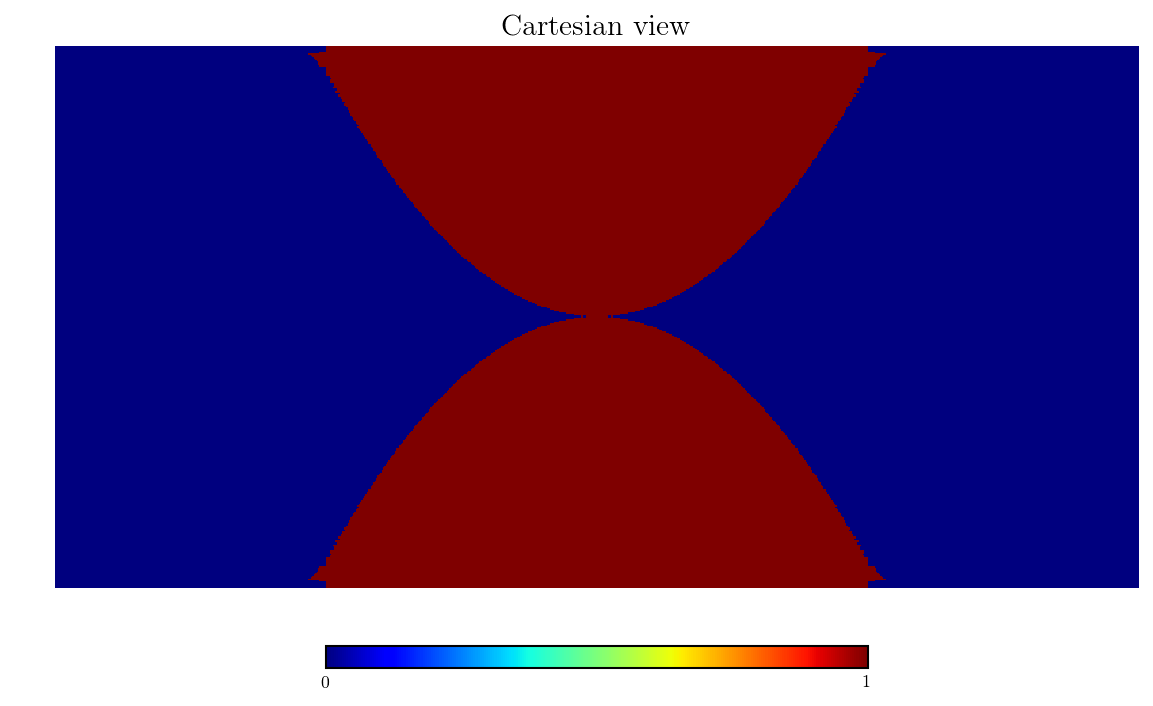

In [33]:
import Tools
parabolic_opening = 0.01 

hpix = np.arange(12*256**2)
l,b = Tools.hpix2ang(hpix)
l[l>180]-=360
template = np.zeros(12*256**2)
template[np.abs(b)>parabolic_opening*l**2] = 1
import healpy
healpy.cartview(template)
